In [1]:
import datetime
from datetime import timedelta
import json
import pickle
import json
import logging
import warnings
import os
import torch.nn as nn
import torch
from tqdm import tqdm
from data.utils import *
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
warnings.filterwarnings('ignore')

class finBert_Sentiment(nn.Module):
    def __init__(
        self,
        MEDIA,
        KEYWORD,
        STOCK,
        DAY_RANGE,
        content_type,
        filename_news,
        filename_price,
        filename_log) -> None:
        super(finBert_Sentiment, self).__init__()
        # Models ------>
        # 1. 'yiyanghkust/finbert-tone'
        # 2. 'ProsusAI/finbert' 
        self.finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',device_map='cuda',num_labels=3)
        self.tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
        self.model = pipeline("sentiment-analysis", model=self.finbert, tokenizer=self.tokenizer)
        
        # Data ------->
        """
        1. News data
        2. Price data
        3. Store the scored data in link_score
        """
        self.data_news = None
        self.data_price = None
        self.link_score = {}
        
        # Some settings        
        self.MEDIA = MEDIA
        self.KEYWORD = KEYWORD
        self.STOCK = STOCK
        self.DAY_RANGE = DAY_RANGE
        self.content_type = content_type
        # Load data
        self.filename_news = filename_news
        self.filename_price = filename_price
        # Store result and error log
        self.filename_log = filename_log
        if os.path.exists(self.filename_log):
            os.remove(self.filename_log)
        logging.basicConfig(filename=self.filename_log, level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
    
    def load_data(self):
        # --------
        # Data
        """
        English data for finBert
        - filename_news:   json file   | data_news = [{link: [date, title, text]}, ...] 
        - filename_price:  pickle file | data_price = [{date: price}, ...]
        """
        assert os.path.exists(self.filename_news) and os.path.exists(self.filename_price), \
            f"Error: data file does not exist"
        with open(self.filename_news, 'r', encoding='utf-8') as f:
            self.data_news = json.load(f)
        with open(self.filename_price, 'rb') as f:
            self.data_price = pickle.load(f)
        
        self.data_price = self.data_price.pct_change().shift(-1).dropna()
        self.data_price.index = self.data_price.index.date
        self.data_price = self.data_price.to_dict()
    
    def scoring(self): 
        # --------
        # Scoring      
        sign = {'Positive': 1, 'Negative': -1, 'Neutral': 0.3}
        for link, info in self.data_news.items():
            if link in self.link_score:
                continue
            time, title, text = info[0], info[1], info[2]
            
            # The news' date: if not in price date, add 1 day until in
            date_news = datetime.datetime.strptime(time[:10], '%Y-%m-%d').date()
            if date_news not in self.data_price:
                if date_news > max(self.data_price.keys()):
                    continue
                else:
                    while date_news not in self.data_price:
                        date_news += timedelta(days=1)          
                        
            # The date's price
            date_price = self.data_price[date_news]
            
            # =======
            # Compute score for each day            
            """
            1. Summary for text
            2. Compute score for each article title and text
            3. link_score = {link: [date, price, score_title, score_text]}
            NOTE:
            - If none scores is added to score, the score == None
            """        
            print('-------')
            
            if self.content_type == 'Text':
                try: # Text
                    summarise_text = summarise(text)
                    result = self.model(summarise_text)
                    score_text = result[0]['score'] * sign[result[0]['label']]
                    print(result[0]['label'])
                except Exception as e:
                    score_text = None
                    logging.error(f'Error occur with text {link} | Error message: {e}')   
                self.link_score[link] = [str(date_news), date_price, score_text]
                    
            elif self.content_type == 'Title':
                try: # Title
                    result = self.model(title)
                    score_title = result[0]['score'] * sign[result[0]['label']]
                    print(result[0]['label'])
                except Exception as e:
                    score_title = None
                    logging.error(f'Error occur with title {link} | Error message: {e}')
                self.link_score[link] = [str(date_news), date_price, score_title]

    def trade(self):
        import pandas as pd
        import numpy as np
        from sklearn.linear_model import LinearRegression
        from sklearn.preprocessing import StandardScaler
        """
        - link_score = {link: [date, price_pct, score_title, score_text]}
        ---
        1. Read data
        2. Set dict data to dataframe
        3. Compute the mean score for each date, title and text
        4. Regression on score and price percentile change
        """
        result_senti_df = pd.DataFrame(self.link_score).T.reset_index(drop=True)
        result_senti_df.columns = ['date', 'price_pct', f'score_{self.content_type}']
        
        if self.content_type == 'Title':
            # Title
            score_title_sum = result_senti_df.groupby('date')['score_Title'].sum()
            price_pct = result_senti_df.groupby('date')['price_pct'].mean()
            result_senti_date_df = pd.DataFrame({ 
                'score_title_sum': score_title_sum, 
                'price_pct': price_pct})
            scaler = StandardScaler()
            result_senti_date_df[['score_title_sum']] = scaler.fit_transform(result_senti_date_df[['score_title_sum']])
            
            # Lag data
            lag = 10
            for l in range(lag):
                result_senti_date_df[f'score_title_sum_lag{l+1}'] = result_senti_date_df['score_title_sum'].shift(l+1)        
            result_senti_date_df.dropna(inplace=True)
            
            # Train and test
            train_data = result_senti_date_df[:int(len(result_senti_date_df)*.8)]
            test_data = result_senti_date_df[int(len(result_senti_date_df)*.8):]
            
            model = LinearRegression()
            model.fit(train_data.drop(['price_pct'], axis=1), train_data[['price_pct']])
            prediction = model.predict(test_data.drop(['price_pct'], axis=1))
            asset_senti = 1
            asset_buyhold = 1
            asset_senti_hist = []
            asset_buyhold_hist = []
            for p, t in zip(prediction, np.array(test_data['price_pct'])):
                if p > 0:
                    asset_senti *= (1 + t)
                asset_buyhold *= (1 + t)
                    
                asset_senti_hist.append(asset_senti)   
                asset_buyhold_hist.append(asset_buyhold)
            
        if self.content_type == 'Text':
            # Text
            score_text_sum = result_senti_df.groupby('date')['score_text'].sum()
            result_senti_date_df = pd.DataFrame({ 
                'score_title_sum': score_title_sum, 
                'score_text_sum': score_text_sum, 
                'price_pct': price_pct})
            scaler = StandardScaler()
            result_senti_date_df[['score_text_sum']] = scaler.fit_transform(result_senti_date_df[['score_text_sum']])
            
            for l in range(lag):
                result_senti_date_df[f'score_text_sum_lag{l+1}'] = result_senti_date_df['score_text_sum'].shift(l+1)
                
            # Train and test
            train_data = result_senti_date_df[:int(len(result_senti_date_df)*.8)]
            test_data = result_senti_date_df[int(len(result_senti_date_df)*.8):]
            
            model = LinearRegression()
            model.fit(train_data.drop(['price_pct'], axis=1), train_data[['price_pct']])
            prediction = model.predict(test_data.drop(['price_pct'], axis=1))
            asset_senti = 1
            asset_buyhold = 1
            asset_senti_hist = []
            asset_buyhold_hist = []
            for p, t in zip(prediction, np.array(test_data['price_pct'])):
                if p > 0:
                    asset_senti *= (1 + t)
                asset_buyhold *= (1 + t)
                    
                asset_senti_hist.append(asset_senti)   
                asset_buyhold_hist.append(asset_buyhold)
        
        return asset_senti_hist, asset_buyhold_hist
        

In [2]:
MEDIA = 'UDN'
KEYWORD = 'ETF'
STOCK = '0050.TW'
DAY_RANGE = '1d'
content_type = 'Title'
filename_news = f'data/TW-stock-news-price/date/NEWS_{MEDIA}_{KEYWORD}_EN.json'
filename_price = f'data/TW-stock-news-price/date/PRICE_{STOCK}_{DAY_RANGE}.pickle'
filename_log = f'logs/finBert_day_ERROR_{MEDIA}_{KEYWORD}'
senti = finBert_Sentiment(MEDIA, KEYWORD, STOCK, DAY_RANGE, content_type, filename_news, filename_price, filename_log)

In [ ]:
senti.load_data()
senti.scoring()
asset_senti, asset_buyhold = senti.trade()

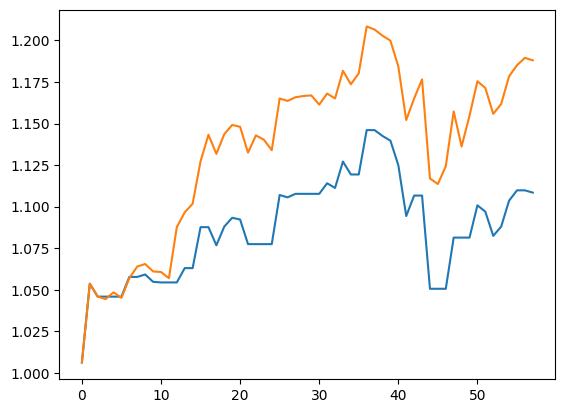

In [5]:
import matplotlib.pyplot as plt
plt.plot(asset_senti)
plt.plot(asset_buyhold)